## Scraping Beer Advocate: all beers from all state lists

In [2]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from datetime import datetime
from geopy.geocoders import Nominatim
from time import sleep
import pickle
import zipcode

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import ensemble, tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

%matplotlib inline

/Users/braeburn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
sns.set_style('darkgrid')

In [2385]:
def to_soup(url):
    """
    Takes url as input and returns soup object.
    """
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    return soup

def get_name(soup):
    """
    Takes soup oject as input and returns string within title tags.
    """
    name_string = soup.find('title').text
    name = name_string.split('|')[0].strip()
    return name

def get_beer_rating(soup):
    """
    Takes soup oject as input and returns beer rating using ba-ravg class.
    """
    avg_rating = soup.find('span', {'class':'ba-ravg'}).text
    return avg_rating

def get_beer_style(soup):
    """
    Takes soup oject as input and returns beer style using 'Style:' text search.
    """
    style_string = soup.find(text='Style:')
    style = style_string.findNext().findNext().text
    return style

def find_abv_index (char, string):
    """
    Finds index of string containing abv percent (i.e. string following
    'Alcohol by'). Returns index number.
    """
    for i in string:
        if char in i:
            return string.index(i) + 1
        
def get_beer_abv(soup):
    """
    Takes soup object as input and uses find_abv_index to return abv percent.
    """
    ba_block = str(soup.find_all(class_ = 'break')[1]).split('</b>')
    abv_long = ba_block[find_abv_index('Alcohol by', ba_block)]
    abv = abv_long.split()[0]
    return abv

def get_beer_year(soup):
    """
    Takes soup object as input uses a regular expression to get the 
    date at the end of the "Added by" string. Returns year as a datetime object.
    """
    addedby = soup.body.findAll(text=re.compile('^Added by*'))
    strdate = addedby[0].split()[-1]
    year = datetime.strptime(strdate, '%m-%d-%Y').year
    return year

def get_brewery(soup):
    """
    Takes soup object as input and returns brewery using 'Brewedy by' text search.
    """
    bb_string = soup.find(text='Brewed by:')
    brewery = bb_string.findNext().findNext().text
    return brewery

def get_state(soup):
    """
    Takes soup object as input and returns state using 'place/directory' href tags.
    """
    if len(soup.find_all('a', href=re.compile(r'place/directory/'))) > 2:
        state = soup.find_all('a', href=re.compile(r'place/directory/'))[2].text[:]
        return state
    else:
        return None

def get_country(soup):
    """
    Takes soup object as input and returns country using 'place/directory' href tags.
    """
    if len(soup.find_all('a', href=re.compile(r'place/directory/'))) > 2:
        country = soup.find_all('a', href=re.compile(r'place/directory/'))[3].text[:]
        return country
    else:
        return None

In [2386]:
def parse_page(url):
    """
    Takes beer page url as input and calls functions to scrape beer attributes.
    Returns tuple of beer name, rating, style, abv, year, brewery, state, country.
    """
    soup = to_soup(url)
    name = get_name(soup)
    rating = get_beer_rating(soup)
    style = get_beer_style(soup)
    abv = get_beer_abv(soup)
    year = get_beer_year(soup)
    brewery = get_brewery(soup)
    state = get_state(soup)
    country = get_country(soup)
    
    attributes = (name, rating, style, abv, year, brewery, state, country)
    
    return attributes

In [2387]:
def get_urls(site, keyword_string):
    """
    Takes a page url and keyword string for href tag. Returns a list of complete
    urls on that page that have specified keywords in href tag. Urls include
    www.beeradvocate.com prefix.
    """
    soup = to_soup(site)
    hrefs = soup.find_all('a', href=re.compile(keyword_string))
    links = []
    for anchor in hrefs:
        links.append(anchor['href'])
    links = ['https://www.beeradvocate.com' + x for x in links]
    return links

In [2388]:
def beer_attrs_to_dict(urls):
    """
    Takes list of beer page urls as input. Scrapes pages for beer attributes 
    ('name', 'rating', 'style', 'abv', 'year', 'brewery', 'state', 'country')
    and returns a list of dictionaries with a dictionary for each beer.
    """
    beer_data = []
    for url in urls:
        beer_info = parse_page(url)
        headers = ['name', 'rating', 'style', 'abv', 'year', 'brewery', 'state', 'country']
        beer_dict = dict(zip(headers, beer_info))
        beer_data.append(beer_dict)
    return beer_data

In [2389]:
# # top 100 beers (not using)

# beer_links = get_urls('https://www.beeradvocate.com/lists/us/', 'beer/profile/' )
# # pick up every other link to only select beer pages (and not brewery ones)
# url_list_top_100 = beer_links[0::2]
# # create dictionary with all beer info for top 100 beers in US
# beer_data = beer_attrs_to_dict(url_list_top_100)

# df = pd.DataFrame(beer_data)
# # df.head()
# df.to_csv('top_100_beers.csv')

# ## to do later: confirm all these beers are in master_df

**Generating list of urls for beer pages and brewery pages**

In [2390]:
# get all state pages
state_links = get_urls('https://www.beeradvocate.com/lists/us/', 'lists/state/')

# for each state page, get all beer profile pages and all brewery pages
all_states_all_beers = []
all_states_all_breweries = []
for link in state_links:
    one_state_all_links = get_urls(link, 'beer/profile/')
    # every other link to just capture beer urls
    one_state_all_beers = one_state_all_links[0::2]
    all_states_all_beers.extend(one_state_all_beers)
    # capturing brewery urls
    one_state_all_breweries = one_state_all_links[1::2]
    all_states_all_breweries.extend(one_state_all_breweries)

In [2391]:
len(all_states_all_beers)

3824

**Scraping beer attributes**

In [2392]:
x = 0
y = 100
headers = ['name', 'rating', 'style', 'abv', 'year', 'brewery', 'state', 'country']
master_df = pd.DataFrame(columns=headers)

while y<len(all_states_all_beers):
    beer_data = beer_attrs_to_dict(all_states_all_beers[x:y])
    print('%d complete' % y)
    x += 100
    y += 100
    df = pd.DataFrame(beer_data)
    master_df = master_df.append(df)
beer_data = beer_attrs_to_dict(all_states_all_beers[y-100:])
print('all complete')
df = pd.DataFrame(beer_data)
master_df = master_df.append(df)

100 complete
200 complete
300 complete
400 complete
500 complete
600 complete
700 complete
800 complete
900 complete
1000 complete
1100 complete
1200 complete
1300 complete
1400 complete
1500 complete
1600 complete
1700 complete
1800 complete
1900 complete
2000 complete
2100 complete
2200 complete
2300 complete
2400 complete
2500 complete
2600 complete
2700 complete
2800 complete
2900 complete
3000 complete
3100 complete
3200 complete
3300 complete
3400 complete
3500 complete
3600 complete
3700 complete
3800 complete
all complete


In [2395]:
master_df.shape

(3824, 8)

In [2396]:
master_df.to_csv('all_states_all_beers.csv')

In [2397]:
master_df.to_pickle('beers_master_df.pkl')

In [ ]:
# possible later scraping steps
# scrape bottom of list
# scrape 250 new beers
# confirm all top 100 are in main list

## scraping part two: brewery pages 

In [ ]:
# scrape all zip codes along with brewery names
# use zipcode package to create dict of brewery, zip code, city, lat, long
# merge with dataframe

In [2399]:
import zipcode

In [2400]:
def get_zipcode(soup):
    """
    Takes soup object as input and returns zipcode using 'place/directory' tags.
    """
    if len(str(soup.find_all(class_ = 'break')[1]).split('/place/directory')[1].split('</a>, ')) > 1:
        zipcode = str(soup.find_all(class_ = 'break')[1]).split('/place/directory')[1].split('</a>, ')[1][:5]
        return zipcode
    else:
        return None

In [2401]:
def get_city_st(soup):
    """
    Takes soup oject as input and returns city using title tags.
    """
    location_string = soup.find('title').text
    location = location_string.split('|')[1].strip()
    return location

In [2402]:
def parse_brewery_page(url):
    """
    Takes brewery page url as input and calls functions to scrape brewery attributes.
    Returns tuple of brewrey name, location string, and zipcode.
    """
    soup = to_soup(url)
    brewery_name = get_name(soup)
    location = get_city_st(soup)
    zipcode = get_zipcode(soup)
        
    brewery_attributes = (brewery_name, location, zipcode)
    
    return brewery_attributes 

In [2403]:
def brewery_dict(urls): 
    """
    Takes list of brewery page urls as input. Scrapes pages for brewery attributes 
    (brewery name, location (city, state), and zipcode) and returns at list
    of dictionaries with a dictionary for each brewery.
    """
    brewery_data = []
    for url in urls:
        brewery_info = parse_brewery_page(url)
        headers = ['brewery_name', 'location', 'zipcode']
        brewery_dict = dict(zip(headers, brewery_info))
        brewery_data.append(brewery_dict)
    return brewery_data

In [2404]:
# # first ten to test
# headers = ['brewery_name', 'location', 'zipcode']
# brewery_df = pd.DataFrame(columns=headers)
# brewery_data = brewery_dict(all_states_all_breweries[0:10])
# df = pd.DataFrame(brewery_data)
# brewery_df = brewery_df.append(df)
# brewery_df

**Scraping brewery attributes**

In [2405]:
x = 0
y = 100
headers = ['zipcode', 'brewery_name']
brewery_df = pd.DataFrame(columns=headers)

while y<len(all_states_all_breweries):
    brewery_data = brewery_dict(all_states_all_breweries[x:y])
    print('%d complete' % y)
    x += 100
    y += 100
    df = pd.DataFrame(brewery_data)
    brewery_df = brewery_df.append(df)
brewery_data = brewery_dict(all_states_all_breweries[y-100:])
print('all complete')
df = pd.DataFrame(brewery_data)
brewery_df = brewery_df.append(df)

100 complete
200 complete
300 complete
400 complete
500 complete
600 complete
700 complete
800 complete
900 complete
1000 complete
1100 complete
1200 complete
1300 complete
1400 complete
1500 complete
1600 complete
1700 complete
1800 complete
1900 complete
2000 complete
2100 complete
2200 complete
2300 complete
2400 complete
2500 complete
2600 complete
2700 complete
2800 complete
2900 complete
3000 complete
3100 complete
3200 complete
3300 complete
3400 complete
3500 complete
3600 complete
3700 complete
3800 complete
all complete


In [2406]:
brewery_df.head()

,brewery_name,location,zipcode
0,Good People Brewing Company,"Birmingham, AL",35233
1,Straight To Ale,"Huntsville, AL",35801
2,Good People Brewing Company,"Birmingham, AL",35233
3,Good People Brewing Company,"Birmingham, AL",35233
4,Good People Brewing Company,"Birmingham, AL",35233


In [2407]:
brewery_df.shape

(3824, 3)

In [2408]:
# save for posterity's sake
brewery_df.to_csv('all_states_all_breweries.csv')
brewery_df.to_pickle('breweries_master_df.pkl')

## Data cleaning and feature engineering

In [1841]:
with open("breweries_master_df.pkl", 'rb') as picklefile: 
    brewery_df = pickle.load(picklefile)

In [1842]:
brewery_df.reset_index(drop = True, inplace = True)
brewery_df.head()

,brewery_name,location,zipcode
0,Good People Brewing Company,"Birmingham, AL",35233
1,Straight To Ale,"Huntsville, AL",35801
2,Good People Brewing Company,"Birmingham, AL",35233
3,Good People Brewing Company,"Birmingham, AL",35233
4,Good People Brewing Company,"Birmingham, AL",35233


**Zipcodes**

In [1843]:
brewery_df[brewery_df.zipcode.isnull()]

,brewery_name,location,zipcode
789,O'Dempsey's,"Atlanta, GA",None
3305,Utah Brewers Cooperative,UT,None
3309,Utah Brewers Cooperative,UT,None
3328,Utah Brewers Cooperative,UT,None
3335,Utah Brewers Cooperative,UT,None
3339,Utah Brewers Cooperative,UT,None
3342,Utah Brewers Cooperative,UT,None
3343,Utah Brewers Cooperative,UT,None
3344,Utah Brewers Cooperative,UT,None
3346,Utah Brewers Cooperative,UT,None


In [1844]:
def add_zipcodes(x):
    name = x.iloc[0]
    if name == 'O\'Dempsey\'s':
        return 30328
    elif name == 'Utah Brewers Cooperative':
        return 84115
    else:
        return x.iloc[2]

In [1845]:
brewery_df['zipcode'] = brewery_df.apply(add_zipcodes, axis=1)

**Latitude and longitude**

In [1846]:
brewery_df.head()

,brewery_name,location,zipcode
0,Good People Brewing Company,"Birmingham, AL",35233
1,Straight To Ale,"Huntsville, AL",35801
2,Good People Brewing Company,"Birmingham, AL",35233
3,Good People Brewing Company,"Birmingham, AL",35233
4,Good People Brewing Company,"Birmingham, AL",35233


In [1847]:
def lat(x):
    myzip = zipcode.isequal(str(x))
    try:
        lat = myzip.lat
        return lat
    except:
        pass

def lon(x):
    myzip = zipcode.isequal(str(x))
    try:
        lon = myzip.lon
        return lon        
    except:
        pass

In [1848]:
brewery_df['lat'] = brewery_df['zipcode'].map(lat)
brewery_df['lon'] = brewery_df['zipcode'].map(lon)

In [1849]:
brewery_df.to_pickle('breweries_clean_master_df.pkl')

### Merge into all beers dataset

In [1850]:
with open("beers_master_df.pkl", 'rb') as picklefile: 
    beers_df = pickle.load(picklefile)

In [1851]:
with open("breweries_clean_master_df.pkl", 'rb') as picklefile: 
    brewery_df = pickle.load(picklefile)

In [1852]:
beers_df.shape

(3824, 8)

In [1853]:
brewery_df.shape

(3824, 5)

In [1854]:
df = pd.concat([beers_df.reset_index(),brewery_df],axis=1)

In [1855]:
df = df.iloc[:, 1:]

In [1856]:
df.shape

(3824, 13)

In [1857]:
df.head()

,abv,brewery,country,name,rating,state,style,year,brewery_name,location,zipcode,lat,lon
0,13.90%,Good People Brewing Company,United States,El Gordo,4.45,Alabama,Russian Imperial Stout,2010.0,Good People Brewing Company,"Birmingham, AL",35233,33.52,-86.79
1,11.70%,Straight To Ale,United States,Cabernet Barrel-Aged Laika Stout,4.3,Alabama,Russian Imperial Stout,2013.0,Straight To Ale,"Huntsville, AL",35801,34.70,-86.62
2,7.40%,Good People Brewing Company,United States,Hitchhiker,4.33,Alabama,American IPA,2010.0,Good People Brewing Company,"Birmingham, AL",35233,33.52,-86.79
3,10.00%,Good People Brewing Company,United States,Snake Handler Double IPA,4.16,Alabama,American Double / Imperial IPA,2009.0,Good People Brewing Company,"Birmingham, AL",35233,33.52,-86.79
4,8.50%,Good People Brewing Company,United States,Fatso,4.22,Alabama,Russian Imperial Stout,2009.0,Good People Brewing Company,"Birmingham, AL",35233,33.52,-86.79


In [1858]:
df.drop('brewery_name', 1, inplace = True)

In [1859]:
df.rename(columns={"style": "beer_style"}, inplace = True)

In [1860]:
df.head()

,abv,brewery,country,name,rating,state,beer_style,year,location,zipcode,lat,lon
0,13.90%,Good People Brewing Company,United States,El Gordo,4.45,Alabama,Russian Imperial Stout,2010.0,"Birmingham, AL",35233,33.52,-86.79
1,11.70%,Straight To Ale,United States,Cabernet Barrel-Aged Laika Stout,4.3,Alabama,Russian Imperial Stout,2013.0,"Huntsville, AL",35801,34.70,-86.62
2,7.40%,Good People Brewing Company,United States,Hitchhiker,4.33,Alabama,American IPA,2010.0,"Birmingham, AL",35233,33.52,-86.79
3,10.00%,Good People Brewing Company,United States,Snake Handler Double IPA,4.16,Alabama,American Double / Imperial IPA,2009.0,"Birmingham, AL",35233,33.52,-86.79
4,8.50%,Good People Brewing Company,United States,Fatso,4.22,Alabama,Russian Imperial Stout,2009.0,"Birmingham, AL",35233,33.52,-86.79


**ABV**

In [1861]:
df['abv'] = df['abv'].str.replace('%', '')
# many abv's are not listed and show up as 'not'
# note: setting to zero for now (note: change later)
df['abv'] = df['abv'].replace('not', '0')
# remove outlier
df['abv'] = df['abv'].replace('29.00', '0')
df['abv'] = pd.to_numeric(df.abv)

In [1862]:
# later date: use Imputer for imputing missing abv values based on average for group
# from sklearn.preprocessing import Imputer
# df['abv'] = df['abv'].str.replace('%', '')
# df['abv'] = df['abv'].replace('not', np.nan)
# #df[df.abv.isnull()]
# #Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

**Year**

In [1863]:
df['year'] = df.year.astype(int)

In [1864]:
# 20 years of beer
df.year.sort_values().unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

**Rating**

In [1865]:
df['rating'] = pd.to_numeric(df.rating)

In [1866]:
df.rating.describe()

count    3824.000000
mean        4.052100
std         0.323076
min         1.840000
25%         3.870000
50%         4.090000
75%         4.272500
max         4.850000
Name: rating, dtype: float64

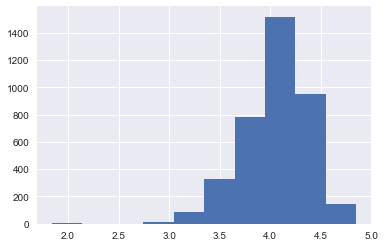

In [1867]:
df.rating.hist()

In [1868]:
# all US data right now so can exclude this from models
df.country.unique()

array(['United States', None], dtype=object)

**Brew counts (brewery size proxy)**

In [1869]:
df.groupby('brewery')['rating'].count().sort_values(ascending = False).head(30)

brewery
Hill Farmstead Brewery              62
Dogfish Head Craft Brewery          51
3 Floyds Brewing Co.                49
Trillium Brewing Company            47
Wicked Weed Brewing                 44
Prairie Artisan Ales                41
Tree House Brewing Company          40
Epic Brewing Company                37
Cigar City Brewing                  36
Pipeworks Brewing Company           36
Allagash Brewing Company            36
Toppling Goliath Brewing Company    34
Abita Brewing Co.                   33
Carton Brewing Company              29
Smuttynose Brewing Company          29
Stillwater Artisanal Ales           27
Jackie O's Pub & Brewery            26
Jester King Brewery                 26
Other Half Brewing Co.              25
New Glarus Brewing Company          25
Uinta Brewing Company               25
Midnight Sun Brewing Co.            24
Tired Hands Brewing Company         24
Surly Brewing Company               24
Alaskan Brewing Co.                 22
Boulevard Brewing

In [1870]:
df['brew_counts'] = df.groupby(['brewery'])['rating'].transform('count')

**Avg rating (of other beers at brewery)**

In [1871]:
# df.groupby('brewery')['rating'].mean().sort_values(ascending = False).head(30)

In [1872]:
df['brewery_avg_rating'] = df.groupby(['brewery'])['rating'].transform('mean')

In [1873]:
# prevent data leakage (from target into training data) and get brewery rating for all other beers by that brewery
df['brewery_avg_rating2'] = ((df.brewery_avg_rating * df.brew_counts) - df.rating) / (df.brew_counts - 1)
# this sets missing values for all breweries with one beer

In [1874]:
# df[df.brewery_avg_rating2.isnull()]

In [1875]:
ratings_by_brewery = df.groupby(['brewery_avg_rating2'])['rating'].transform('mean')

In [1876]:
ratings_by_brewery.describe()

count    3568.000000
mean        4.051757
std         0.317286
min         1.840000
25%         3.870000
50%         4.100000
75%         4.270000
max         4.840000
Name: rating, dtype: float64

In [1877]:
mean = ratings_by_brewery.mean()

In [1878]:
df.drop('brewery_avg_rating', 1, inplace = True)

In [1879]:
df['brewery_avg_rating2'].fillna(mean, inplace = True)
# replacing with mean for (256) breweries with only one beer (avoid missing values)

# initial test used zero as a starting point (results is lower R2 in linear regression)
# df['brewery_avg_rating2'].fillna(0, inplace = True)

**Beer style taxonomy: take 1**

In [1880]:
# df.beer_style.unique()

In [1881]:
# beer taxonomy

In [1882]:
american_ales = ['American Amber / Red Ale',
                    'American Barleywine',
                    'American Black Ale',
                    'American Blonde Ale',
                    'American Brown Ale',
                    'American Dark Wheat Ale',
                    'American Double / Imperial IPA',
                    'American Double / Imperial Stout',
                    'American IPA',
                    'American Pale Ale (APA)',
                    'American Pale Wheat Ale',
                    'American Porter',
                    'American Stout',
                    'American Strong Ale',
                    'American Wild Ale',
                    'Black & Tan',
                    'Chile Beer',
                    'Cream Ale',
                    'Pumpkin Ale',
                    'Rye Beer',
                    'Wheatwine']

In [1883]:
belgian_french_ales = ['Belgian Dark Ale',
                        'Belgian IPA',
                        'Belgian Pale Ale',
                        'Belgian Strong Dark Ale',
                        'Belgian Strong Pale Ale',
                        'Bière de Champagne / Bière Brut',
                        'Bière de Garde',
                        'Dubbel',
                        'Faro',
                        'Flanders Oud Bruin',
                        'Flanders Red Ale',
                        'Gueuze',
                        'Lambic - Fruit',
                        'Lambic - Unblended',
                        'Quadrupel (Quad)',
                        'Saison / Farmhouse Ale',
                        'Tripel',
                        'Witbier']

In [1884]:
english_ales = ['Baltic Porter',
                'Braggot',
                'English Barleywine',
                'English Bitter',
                'English Brown Ale',
                'English Dark Mild Ale',
                'English India Pale Ale (IPA)',
                'English Pale Ale',
                'English Pale Mild Ale',
                'English Porter',
                'English Stout',
                'English Strong Ale',
                'Extra Special / Strong Bitter (ESB)',
                'Foreign / Export Stout',
                'Milk / Sweet Stout',
                'Oatmeal Stout',
                'Old Ale',
                'Russian Imperial Stout',
                'Winter Warmer']

In [1885]:
finnish_ales = ['Sahti']

In [1886]:
german_ales = ['Altbier',
                'Berliner Weissbier',
                'Dunkelweizen',
                'Gose',
                'Hefeweizen',
                'Kölsch',
                'Kristalweizen',
                'Roggenbier',
                'Weizenbock']

In [1887]:
irish_ales = ['Irish Dry Stout', 'Irish Red Ale']

In [1888]:
russian_ales = ['Kvass']

In [1889]:
scottish_ales = ['Scotch Ale / Wee Heavy',
                'Scottish Ale',
                'Scottish Gruit / Ancient Herbed Ale']

In [1890]:
american_lagers = ['American Adjunct Lager',
                    'American Amber / Red Lager',
                    'American Double / Imperial Pilsner',
                    'American Malt Liquor',
                    'American Pale Lager',
                    'California Common / Steam Beer',
                    'Light Lager',
                    'Low Alcohol Beer']

In [1891]:
czech_lagers = ['Czech Pilsener']

In [1892]:
european_lagers = ['Euro Dark Lager',
                    'Euro Pale Lager',
                    'Euro Strong Lager']

In [1893]:
german_lagers = ['Bock',
                'Doppelbock',
                'Dortmunder / Export Lager',
                'Eisbock',
                'German Pilsener',
                'Kellerbier / Zwickelbier',
                'Maibock / Helles Bock',
                'Märzen / Oktoberfest',
                'Munich Dunkel Lager',
                'Munich Helles Lager',
                'Rauchbier',
                'Schwarzbier',
                'Vienna Lager']

In [1894]:
japanese_lagers = ['Happoshu', 'Japanese Rice Lager']

In [1895]:
hybrid_beers = ['Fruit / Vegetable Beer',
                'Herbed / Spiced Beer',
                'Smoked Beer']

In [1896]:
ales = [american_ales, belgian_french_ales, english_ales, finnish_ales, german_ales, irish_ales, 
                 russian_ales, scottish_ales]
lagers = [american_lagers, czech_lagers, european_lagers, german_lagers, japanese_lagers]
# hybrid_beers

In [1897]:
df['american_ale'] = 0
df['american_ale'] = df['beer_style'].map(lambda x: 1 if x in american_ales else 0)

df['belgian_french_ale'] = 0
df['belgian_french_ale'] = df['beer_style'].map(lambda x: 1 if x in belgian_french_ales else 0)

df['english_ale'] = 0
df['english_ale'] = df['beer_style'].map(lambda x: 1 if x in english_ales else 0)

df['finnish_ale'] = 0
df['finnish_ale'] = df['beer_style'].map(lambda x: 1 if x in finnish_ales else 0)

df['german_ale'] = 0
df['german_ale'] = df['beer_style'].map(lambda x: 1 if x in german_ales else 0)

df['irish_ale'] = 0
df['irish_ale'] = df['beer_style'].map(lambda x: 1 if x in irish_ales else 0)

df['russian_ale'] = 0
df['russian_ale'] = df['beer_style'].map(lambda x: 1 if x in russian_ales else 0)

df['scottish_ale'] = 0
df['scottish_ale'] = df['beer_style'].map(lambda x: 1 if x in scottish_ales else 0)

df['american_lager'] = 0
df['american_lager'] = df['beer_style'].map(lambda x: 1 if x in american_lagers else 0)

df['czech_lager'] = 0
df['czech_lager'] = df['beer_style'].map(lambda x: 1 if x in czech_lagers else 0)

df['european_lager'] = 0
df['european_lager'] = df['beer_style'].map(lambda x: 1 if x in european_lagers else 0)

df['german_lager'] = 0
df['german_lager'] = df['beer_style'].map(lambda x: 1 if x in german_lagers else 0)

df['japanese_lager'] = 0
df['japanese_lager'] = df['beer_style'].map(lambda x: 1 if x in japanese_lagers else 0)

df['hybrid_beer'] = 0
df['hybrid_beer'] = df['beer_style'].map(lambda x: 1 if x in hybrid_beers else 0)


In [1898]:
df.columns[14:]

Index(['american_ale', 'belgian_french_ale', 'english_ale', 'finnish_ale',
       'german_ale', 'irish_ale', 'russian_ale', 'scottish_ale',
       'american_lager', 'czech_lager', 'european_lager', 'german_lager',
       'japanese_lager', 'hybrid_beer'],
      dtype='object')

In [1899]:
beer_dummies = df.columns[14:]

In [1900]:
# confirming all beers are cateogrized once
df[beer_dummies].sum(axis=1).sort_values().head()

0       1
2542    1
2543    1
2544    1
2545    1
dtype: int64

In [1901]:
df[beer_dummies].sum(axis=1).sort_values().tail(5)

1279    1
1280    1
1281    1
1269    1
3823    1
dtype: int64

In [1902]:
df.columns

Index(['abv', 'brewery', 'country', 'name', 'rating', 'state', 'beer_style',
       'year', 'location', 'zipcode', 'lat', 'lon', 'brew_counts',
       'brewery_avg_rating2', 'american_ale', 'belgian_french_ale',
       'english_ale', 'finnish_ale', 'german_ale', 'irish_ale', 'russian_ale',
       'scottish_ale', 'american_lager', 'czech_lager', 'european_lager',
       'german_lager', 'japanese_lager', 'hybrid_beer'],
      dtype='object')

**State**

In [1903]:
count_per_state = df.groupby(['state'])['rating'].count()

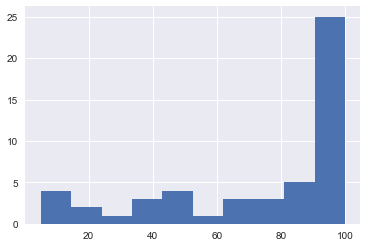

In [1904]:
# 25 states have 100 beers
# 51 'states' as DC is included
count_per_state.hist();

In [1905]:
#count_per_state.sort_values()

In [1906]:
# fix none state
df.state.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       None, 'Vermont', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [1907]:
#df[df.country.isnull()]

In [1908]:
df['state'].fillna('Utah', inplace = True)
df['country'].fillna('United States', inplace = True)

In [1909]:
# state dummies
states = pd.get_dummies(df.state)

In [1910]:
states.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1911]:
df = pd.concat([df, states], axis=1)

In [1912]:
df.columns

Index(['abv', 'brewery', 'country', 'name', 'rating', 'state', 'beer_style',
       'year', 'location', 'zipcode', 'lat', 'lon', 'brew_counts',
       'brewery_avg_rating2', 'american_ale', 'belgian_french_ale',
       'english_ale', 'finnish_ale', 'german_ale', 'irish_ale', 'russian_ale',
       'scottish_ale', 'american_lager', 'czech_lager', 'european_lager',
       'german_lager', 'japanese_lager', 'hybrid_beer', 'Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', '

**Beer style taxonomy: take 2 (individual dummies)**

In [1913]:
b_styles = pd.get_dummies(df.beer_style)

In [1914]:
df2 = pd.concat([df, b_styles], axis = 1)

In [1915]:
df2.columns

Index(['abv', 'brewery', 'country', 'name', 'rating', 'state', 'beer_style',
       'year', 'location', 'zipcode',
       ...
       'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Scottish Gruit / Ancient Herbed Ale', 'Smoked Beer', 'Tripel',
       'Vienna Lager', 'Weizenbock', 'Wheatwine', 'Winter Warmer', 'Witbier'],
      dtype='object', length=173)

In [1916]:
df2.to_pickle('full_df.pkl')

**Create matrices**

In [1917]:
# with open("full_df.pkl", 'rb') as picklefile: 
#     df2 = pickle.load(picklefile)
    
# # df2.to_csv('beers_and_breweries.csv')

In [1918]:
X = df2.drop(['brewery', 'country', 'name', 'rating', 'state', 'beer_style', 'location'], 1)

In [1919]:
y = df2[['rating']]

In [1920]:
s_train, s_test, ytrain, ytest = train_test_split(X, y, test_size = 0.3)

In [1921]:
ytrain = np.ravel(ytrain)
ytest = np.ravel(ytest)
y = np.ravel(y)

## Analysis

In [1922]:
# for i,j in enumerate(s_train):
#     print(i, j)

In [1923]:
# select first beer taxonomy and no location (original model)
Xtrain1 = s_train.drop(s_train.iloc[:, 72:], 1)
Xtrain1 = Xtrain1.drop(s_train.iloc[:, 2:5], 1)
# Xtrain1 = Xtrain1.drop(s_train.iloc[:, 3:5], 1) # zipcode
Xtest1 = s_test.drop(s_test.iloc[:, 72:], 1)
Xtest1 = Xtest1.drop(s_test.iloc[:, 2:5], 1)
#Xtest1 = Xtest1.drop(s_test.iloc[:, 3:5], 1) # zipcode

In [1924]:
# select second beer taxonomy (and no location)
Xtrain2 = s_train.drop(s_train.iloc[:, 7:21], 1)
Xtrain2 = Xtrain2.drop(s_train.iloc[:, 2:5], 1)
Xtest2 = s_test.drop(s_test.iloc[:, 7:21], 1)
Xtest2 = Xtest2.drop(s_test.iloc[:, 2:5], 1)

In [1925]:
# for i,j in enumerate(Xtrain2):
#     print(i, j)

In [1926]:
def run_linear_models(xtrain_data, xtest_data):
    models = {}
    models['lin_reg'] = LinearRegression()
    models['ridge'] = Ridge()
    models['lasso1'] = Lasso(alpha=.2)
    models['lasso2'] = Lasso(alpha=.02)
    models['lasso3'] = Lasso(alpha=.002)
    models['lasso4'] = Lasso(alpha=.0002)
    #models['lasso5'] = Lasso(alpha=.00002)
    models['elasticnet'] = ElasticNet()
    
    for name,model in models.items():
        model.fit(xtrain_data, ytrain)
        print('Model: ' + name)
        print("Score: " + str(model.score(xtest_data, ytest)))
        print("")

In [1927]:
# notes on linear regression:
# initially around .63; jumped up to .69/.70 with adjustment of missing values for brew_avg_rating (from zero to mean)

In [1928]:
# # example of cross_val_score 
# X.drop(['lat', 'lon'], 1, inplace = True)
# cross_val_score(models['lasso3'], X, y)

In [1929]:
print('Taxonomy one - large categories')
run_linear_models(Xtrain1, Xtest1)
# lasso 3 is probably optimal of all the alpha values

Taxonomy one - large categories
Model: lin_reg
Score: 0.703675149527

Model: ridge
Score: 0.704324864037

Model: lasso1
Score: 0.201836817211

Model: lasso2
Score: 0.626721034406

Model: lasso3
Score: 0.694474961429

Model: lasso4
Score: 0.70450897568

Model: elasticnet
Score: 0.0242364748944



In [1930]:
# model = models['lasso3']
# model.fit(Xtrain1, ytrain)
# model.score(Xtest1, ytest)
# model.coef_

# model = models['lin_reg']
# model.fit(Xtrain1, ytrain)
# model.score(Xtest1, ytest)
# model.coef_

# Xtrain1.head()

In [1931]:
print('Taxonomy two - individual dummies')
run_linear_models(Xtrain2, Xtest2)

Taxonomy two - individual dummies
Model: lin_reg
Score: -4.22830858489e+15

Model: ridge
Score: 0.732085427136

Model: lasso1
Score: 0.201836817211

Model: lasso2
Score: 0.626721034406

Model: lasso3
Score: 0.696437416448

Model: lasso4
Score: 0.725552385671

Model: elasticnet
Score: 0.0242364748944



In [1932]:
def run_tree_models(xtrain_data, xtest_data):
    trees = {}

    trees['cart'] = tree.DecisionTreeRegressor(max_depth=7)
    trees['extratrees'] =tree.ExtraTreeRegressor(max_depth=7)
    trees['randomForest'] = RandomForestRegressor()
    trees['rftree1'] = RandomForestRegressor(n_estimators = 10, max_features='auto', min_samples_split=10)
    trees['rftree2'] = RandomForestRegressor(n_estimators = 30, max_features='auto', min_samples_split=10)
    trees['rftree3'] = RandomForestRegressor(n_estimators = 50, max_features='auto', min_samples_split=10)
    trees['rftree4'] = RandomForestRegressor(n_estimators = 100, max_features='auto', min_samples_split=10)
    trees['bagged_randomForest'] = BaggingRegressor(RandomForestRegressor())
    trees['adaboostedTrees'] = ensemble.AdaBoostRegressor()
    trees['gradboostedTrees'] = ensemble.GradientBoostingRegressor()
    
    for name,model in trees.items():
        model.fit(xtrain_data, ytrain)
        print('Model: ' + name)
        print("Score: " + str(model.score(xtest_data, ytest)))
        print("")

In [1933]:
print('Taxonomy one - large categories')
run_tree_models(Xtrain1, Xtest1)

Taxonomy one - large categories
Model: cart
Score: 0.686313520759

Model: extratrees
Score: 0.630973149915

Model: randomForest
Score: 0.742095459589

Model: rftree1
Score: 0.716500884159

Model: rftree2
Score: 0.742437129899

Model: rftree3
Score: 0.743389042182

Model: rftree4
Score: 0.743451708519

Model: bagged_randomForest
Score: 0.746565544593

Model: adaboostedTrees
Score: 0.64661994809

Model: gradboostedTrees
Score: 0.729300238555



In [1934]:
print('Taxonomy two - individual dummies')
run_tree_models(Xtrain2, Xtest2)

Taxonomy two - individual dummies
Model: cart
Score: 0.682593074064

Model: extratrees
Score: 0.614917698701

Model: randomForest
Score: 0.734156652965

Model: rftree1
Score: 0.720796689439

Model: rftree2
Score: 0.746470143734

Model: rftree3
Score: 0.746789697101

Model: rftree4
Score: 0.746667380394

Model: bagged_randomForest
Score: 0.752828721181

Model: adaboostedTrees
Score: 0.67586306763

Model: gradboostedTrees
Score: 0.732597210125



In [1935]:
def sorted_features(model, Xtrain_data, Xtest_data):
    model.fit(Xtrain_data, ytrain)
    print("Score: " + str(model.score(Xtest_data,ytest)))
    sorted_features = sorted(zip(Xtrain_data.columns,model.feature_importances_), key = lambda x: x[1], reverse = True)
    for feature in sorted_features:
        print(feature)

In [1936]:
sorted_features(trees['randomForest'], Xtrain1, Xtest1)

Score: 0.731754801626
('brewery_avg_rating2', 0.70867741719315747)
('abv', 0.10267378814345225)
('year', 0.039446555919869411)
('brew_counts', 0.029126622400104402)
('Nevada', 0.0079236688887161667)
('american_ale', 0.0070277960621107013)
('american_lager', 0.0063946608848059732)
('Louisiana', 0.0059781927409968613)
('Arizona', 0.0049527609583411795)
('Rhode Island', 0.0035906487356031106)
('Kansas', 0.0035062343611414215)
('hybrid_beer', 0.0030051486353183223)
('Oklahoma', 0.0029739680422245451)
('New Jersey', 0.0028201273233958773)
('german_ale', 0.0027285490864835207)
('Missouri', 0.0026344736395966023)
('belgian_french_ale', 0.00262040527684336)
('West Virginia', 0.0025779665221006992)
('South Carolina', 0.0025311289177358245)
('english_ale', 0.0024111125824364823)
('Connecticut', 0.002311808834915783)
('Tennessee', 0.0022891859417932679)
('California', 0.0022616587490585502)
('New York', 0.0021962993896455724)
('Maryland', 0.0020973153529549905)
('Montana', 0.0020028827254161279)


In [1937]:
degree = 3

In [1938]:
# est = make_pipeline(PolynomialFeatures(degree), RandomForestRegressor())
# est.fit(Xtrain1, ytrain)
# est.score(Xtest1, ytest)

In [1939]:
X.columns

Index(['abv', 'year', 'zipcode', 'lat', 'lon', 'brew_counts',
       'brewery_avg_rating2', 'american_ale', 'belgian_french_ale',
       'english_ale',
       ...
       'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Scottish Gruit / Ancient Herbed Ale', 'Smoked Beer', 'Tripel',
       'Vienna Lager', 'Weizenbock', 'Wheatwine', 'Winter Warmer', 'Witbier'],
      dtype='object', length=166)

In [1944]:
nondummies = X.iloc[:, [0, 1, 5, 6]]

In [1945]:
nondummies.columns

Index(['abv', 'year', 'brew_counts', 'brewery_avg_rating2'], dtype='object')

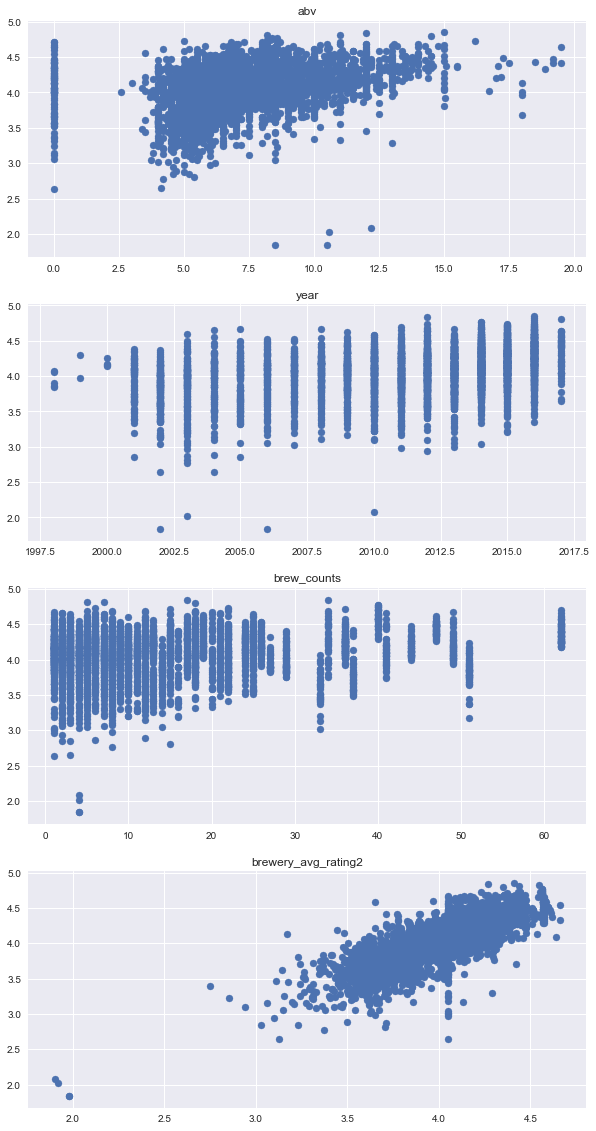

In [1946]:
fig,ax = plt.subplots(ncols=1,nrows=len(nondummies.columns),figsize=(10, 20))

for i,feature in enumerate(nondummies):
    ax[i].scatter(X[feature],y)
    ax[i].set_title(str(feature))

In [5]:
# # individual plot
# fig,ax = plt.subplots(1, 1,figsize=(15, 10))
# ax.scatter(X.brewery_avg_rating2, y)
# ax.ylabel('Beer rating')
# ax.xlabel('Brewery average rating')

In [1948]:
# what happens if just have non dummy variables (abv, brew_counts, avg_rating, year)

Xtrain_lim = Xtrain1.iloc[:, :4]
Xtest_lim = Xtest1.iloc[:, :4]

# what happens if have four main PLUS four beers w/ highest feature importance: 
# American Malt Liquor, American Amber / Red Ale, American Double / Imperial Stout, American Porter

Xtrain_lim2 = Xtrain2.iloc[:, [0, 1, 2, 3, 68, 57, 66, 72]]
Xtest_lim2 = Xtest2.iloc[:, [0, 1, 2, 3, 68, 57, 66, 72]]

# what if I add zip codes in to the top four

Xtrain_lim3 = s_train.iloc[:, [0, 1, 2, 5, 6]]
Xtest_lim3 = s_test.iloc[:, [0, 1, 2, 5, 6]]

# top four, zip codes, four beers (doesn't help)
# Xtrain_x = s_train.iloc[:, [0, 1, 2, 5, 6, 85, 74, 83, 89]]
# Xtest_x = s_test.iloc[:, [0, 1, 2, 5, 6, 85, 74, 83, 89]]

In [1949]:
# # linear models

# print('top four vars')
# run_linear_models(Xtrain_lim, Xtest_lim)

# print('top four vars plus top four beers')
# run_linear_models(Xtrain_lim2, Xtest_lim2)

# print('top four vars plus zip codes')
# run_linear_models(Xtrain_lim3, Xtest_lim3)

In [1950]:
print('top four vars')
run_tree_models(Xtrain_lim, Xtest_lim)

top four vars
Model: cart
Score: 0.685309491033

Model: extratrees
Score: 0.577240837792

Model: randomForest
Score: 0.714222257304

Model: rftree1
Score: 0.708687673274

Model: rftree2
Score: 0.721238237281

Model: rftree3
Score: 0.719985859664

Model: rftree4
Score: 0.726740040866

Model: bagged_randomForest
Score: 0.73391176673

Model: adaboostedTrees
Score: 0.656299450372

Model: gradboostedTrees
Score: 0.718581233659



In [1951]:
print('top four vars plus top four beers')
run_tree_models(Xtrain_lim2, Xtest_lim2)

top four vars plus top four beers
Model: cart
Score: 0.686622467456

Model: extratrees
Score: 0.659698055736

Model: randomForest
Score: 0.710749420631

Model: rftree1
Score: 0.708930035305

Model: rftree2
Score: 0.72586849276

Model: rftree3
Score: 0.727408468458

Model: rftree4
Score: 0.728558456959

Model: bagged_randomForest
Score: 0.735418186183

Model: adaboostedTrees
Score: 0.655458671186

Model: gradboostedTrees
Score: 0.724836026421



In [1952]:
print('top four vars plus zip codes')
run_tree_models(Xtrain_lim3, Xtest_lim3)

top four vars plus zip codes
Model: cart
Score: 0.684454312991

Model: extratrees
Score: 0.651499548025

Model: randomForest
Score: 0.724894626343

Model: rftree1
Score: 0.716273619144

Model: rftree2
Score: 0.735744758889

Model: rftree3
Score: 0.739697653316

Model: rftree4
Score: 0.739455980991

Model: bagged_randomForest
Score: 0.737866967072

Model: adaboostedTrees
Score: 0.643838135106

Model: gradboostedTrees
Score: 0.719801403994



In [1953]:
## just looking at best random forest model

def rftree_2(Xtrain_data, Xtest_data):
    model = RandomForestRegressor(n_estimators = 30, max_features='auto', min_samples_split=10)
    model.fit(Xtrain_data,ytrain)
    print('Model: rftree2')
    print("Score: " + str(model.score(Xtest_data,ytest)))
    print("")


In [1954]:
print('top four vars')
rftree_2(Xtrain_lim, Xtest_lim)

print('top four vars plus top four beers')
rftree_2(Xtrain_lim2, Xtest_lim2)

print('top four vars plus zip codes')
rftree_2(Xtrain_lim3, Xtest_lim3)

top four vars
Model: rftree2
Score: 0.718393908812

top four vars plus top four beers
Model: rftree2
Score: 0.729742582891

top four vars plus zip codes
Model: rftree2
Score: 0.726570864918



In [1955]:
# BEST MODEL IS SIMPLEST WITH ZIP CODES THAT ADD ADDIITONAL PERCENT OR TWO
# rftree2 with five variables (avg rating, abv, year, brew_counts, zip)
# trees['rftree2'] = RandomForestRegressor(n_estimators = 30, max_features='auto', min_samples_split=10)

In [1956]:
sorted_features(trees['rftree2'], Xtrain_lim3, Xtest_lim3)

Score: 0.737983565204
('brewery_avg_rating2', 0.76522029850938722)
('abv', 0.10923387766736398)
('zipcode', 0.055850476590261079)
('year', 0.040770966047377691)
('brew_counts', 0.028924381185609926)


In [1957]:
## minor exploration on feature importance and how it shifts R2

# five vars: abv, year, brew_counts, avg_ratin, zip codes
print('best model: five vars')
rftree_2(Xtrain_lim3, Xtest_lim3)

# what if I get rid of avg beer rating
Xtrain_lim4 = s_train.iloc[:, [0, 1, 2, 5]]
Xtest_lim4 = s_test.iloc[:, [0, 1, 2, 5]]

print('without avg_rating')
rftree_2(Xtrain_lim4, Xtest_lim4)

# what if I get rid of avg beer rating and zipcode
Xtrain_lim5 = s_train.iloc[:, [0, 1, 5]]
Xtest_lim5 = s_test.iloc[:, [0, 1, 5]]

print('without avg_rating and zipcode')
rftree_2(Xtrain_lim5, Xtest_lim5)

best model: five vars
Model: rftree2
Score: 0.736178681732

without avg_rating
Model: rftree2
Score: 0.616170565077

without avg_rating and zipcode
Model: rftree2
Score: 0.365010026253



## Viz exploration

In [1958]:
# df2.head()

In [1959]:
df2.head()

,abv,brewery,country,name,rating,state,beer_style,year,location,zipcode,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
0,13.9,Good People Brewing Company,United States,El Gordo,4.45,Alabama,Russian Imperial Stout,2010,"Birmingham, AL",35233,...,0,0,0,0,0,0,0,0,0,0
1,11.7,Straight To Ale,United States,Cabernet Barrel-Aged Laika Stout,4.30,Alabama,Russian Imperial Stout,2013,"Huntsville, AL",35801,...,0,0,0,0,0,0,0,0,0,0
2,7.4,Good People Brewing Company,United States,Hitchhiker,4.33,Alabama,American IPA,2010,"Birmingham, AL",35233,...,0,0,0,0,0,0,0,0,0,0
3,10.0,Good People Brewing Company,United States,Snake Handler Double IPA,4.16,Alabama,American Double / Imperial IPA,2009,"Birmingham, AL",35233,...,0,0,0,0,0,0,0,0,0,0
4,8.5,Good People Brewing Company,United States,Fatso,4.22,Alabama,Russian Imperial Stout,2009,"Birmingham, AL",35233,...,0,0,0,0,0,0,0,0,0,0


In [1960]:
# df2.corr()

In [1961]:
# 94 unique beer styles
len(df2.beer_style.unique())

94

In [1962]:
# top 10 highest rated beer styles
ds = df2.groupby('beer_style')['rating'].mean().reset_index()
ds.sort_values('rating', ascending = False).head(10)

,beer_style,rating
27,Bière de Champagne / Bière Brut,4.450000
59,Gueuze,4.373333
40,Eisbock,4.355000
11,American Double / Imperial Stout,4.283497
9,American Double / Imperial IPA,4.244880
20,American Wild Ale,4.242000
41,English Barleywine,4.237931
67,Lambic - Fruit,4.228667
54,Flanders Red Ale,4.208571
79,Russian Imperial Stout,4.207260


In [1963]:
# for i,j in enumerate(df2):
#     print(i,j)

In [1964]:
map_df = df2.iloc[:, [1, 4, 5, 6, 10, 11]]

In [1965]:
map_df.head()

,brewery,rating,state,beer_style,lat,lon
0,Good People Brewing Company,4.45,Alabama,Russian Imperial Stout,33.52,-86.79
1,Straight To Ale,4.30,Alabama,Russian Imperial Stout,34.70,-86.62
2,Good People Brewing Company,4.33,Alabama,American IPA,33.52,-86.79
3,Good People Brewing Company,4.16,Alabama,American Double / Imperial IPA,33.52,-86.79
4,Good People Brewing Company,4.22,Alabama,Russian Imperial Stout,33.52,-86.79


In [1966]:
map_df = map_df[map_df.state != 'Hawaii']
map_df = map_df[map_df.state != 'Alaska']

In [1967]:
avg_map_df = map_df.groupby(['brewery', 'lat', 'lon'])['rating'].mean().sort_values(ascending = False).reset_index()

In [1968]:
# breweries with highest beer rating avg
avg_map_df.head(10)

,brewery,lat,lon,rating
0,Brick & Feather Brewery,42.59,-72.55,4.650000
1,Monkish Brewing Co.,33.83,-118.31,4.600000
2,Sand City Brewing Co.,40.90,-73.34,4.584286
3,Bottle Logic Brewing,33.83,-117.86,4.583333
4,Moonraker Brewing Company,39.00,-121.09,4.570000
5,Tree House Brewing Company,42.09,-72.31,4.568750
6,Night Shift Brewing,42.40,-71.05,4.560000
7,Angry Chair Brewing,27.95,-82.48,4.514000
8,Sante Adairius Rustic Ales,36.97,-121.95,4.506000
9,Hangar 24 Brewery,34.06,-117.17,4.495000


In [1969]:
avg_map_df['rating'].describe()

count    549.000000
mean       4.000654
std        0.321165
min        1.945000
25%        3.840000
50%        4.060000
75%        4.210000
max        4.650000
Name: rating, dtype: float64

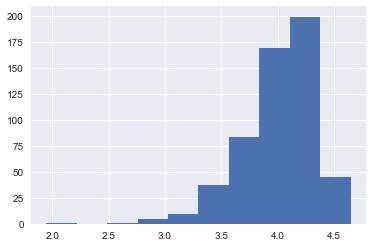

In [1970]:
avg_map_df['rating'].hist()

In [1971]:
def rating(x):
    if x> 4.6:
        return 7
    elif x>=4.3 and x<4.6:
        return 6
    elif x>=4.0 and x<4.3:
        return 5
    elif x>=3.99999:
        return 4
    elif x>=3.5 and x<3.9999:
        return 3
    elif x>=3 and x<3.5:
        return 2
    else:
        return 1

In [1972]:
avg_map_df['rating_cat'] = 0
avg_map_df['rating_cat'] = avg_map_df.rating.map(rating)

In [1974]:
# avg_map_df.sort_values('rating_cat', ascending = False)

In [1975]:
sns.set_style('white')

In [1976]:
pal = sns.color_palette("RdBu", n_colors=7)

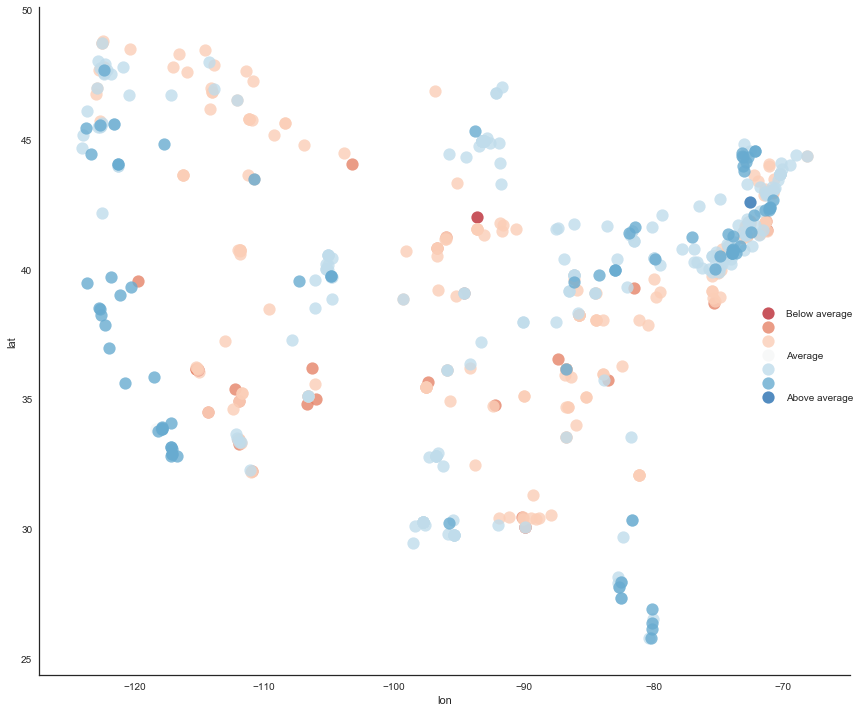

In [1977]:
# sns.lmplot('lon', 'lat', data=avg_map_df, hue='rating_cat', palette = pal, fit_reg=False, size = 10, \
#            aspect = 1.2, scatter_kws={"s": 150})

g = sns.lmplot('lon', 'lat', data=avg_map_df, hue='rating_cat', palette = pal, fit_reg=False, size = 10, \
           aspect = 1.2, scatter_kws={"s": 150}, legend = False)

handles = g._legend_data.values()
labels = ['Below average', '', '', 'Average', '', '', 'Above average']
g.fig.legend(handles=handles, labels=labels, loc='right')

In [1980]:
# Olde Main Brewing Co in Iowa is dark red dot

In [1981]:
# at a later date, would be cool to do scatter plots of rating by beer style